In [5]:
import os, sys, time
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import json
import numpy as np
from collections import defaultdict
from scipy import stats
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms, transforms_c100
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import torch
device = get_device()

Device: cuda


In [6]:
ds_name = "c100"
k = 0
tgt_rank = 1
# pretrained modelのロード
pretrained_dir = getattr(ViTExperiment, ds_name).OUTPUT_DIR.format(k=k)
model = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
model.eval()
# 対象の設定
start_li = 0
target_li = -1
end_li = model.vit.config.num_hidden_layers

# datasetごとに違う変数のセット
if ds_name == "c10":
    tf_func = transforms
    label_col = "label"
    num_labels = 10
elif ds_name == "c100":
    tf_func = transforms_c100
    label_col = "fine_label"
    num_labels = 100
else:
    NotImplementedError

vscore_before_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores_before")
vscore_after_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores_after")
vscore_med_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", "vscores")
tgt_split = "repair"

misclf_info_dir = os.path.join(pretrained_dir, "misclf_info")
# インデックスのロード
with open(os.path.join(misclf_info_dir, f"{tgt_split}_mis_indices.pkl"), "rb") as f:
    mis_indices = pickle.load(f)
# ランキングのロード
with open(os.path.join(misclf_info_dir, f"{tgt_split}_mis_ranking.pkl"), "rb") as f:
    mis_ranking = pickle.load(f)
# ランキングから対象の誤分類情報を取り出す
slabel, tlabel, mis = mis_ranking[tgt_rank-1]
tgt_mis_indices = mis_indices[slabel][tlabel]
print(f"tgt_misclf: {slabel} -> {tlabel}, len(tgt_mis_indices): {len(tgt_mis_indices)}")

tgt_misclf: 52 -> 47, len(tgt_mis_indices): 19


# ViTレイヤの最終層から2層目

ba: before, tgt_split: repair
vscores shape (cor): (768, 12)
vscores shape (mis): (768, 12)
sum(condition)=77


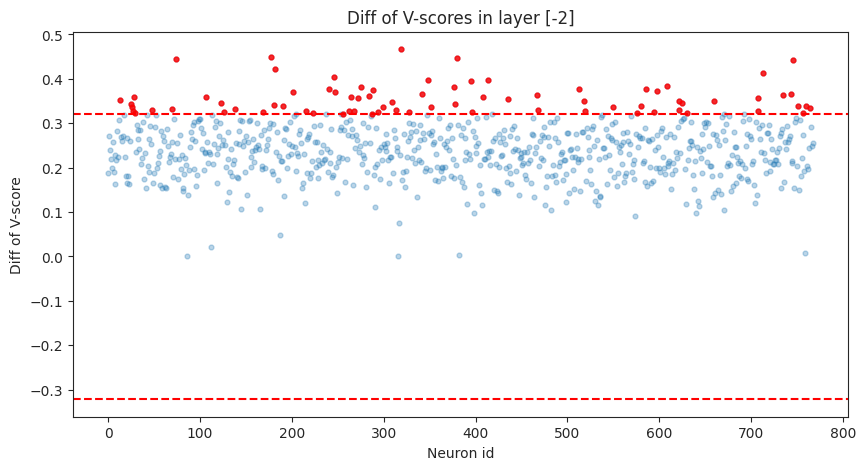

cosine_similarity=[0.90370574 0.90608983 0.91007541 0.91882469 0.91712524 0.91707161
 0.91469489 0.91541015 0.91966586 0.9203881  0.91918057 0.89678558]


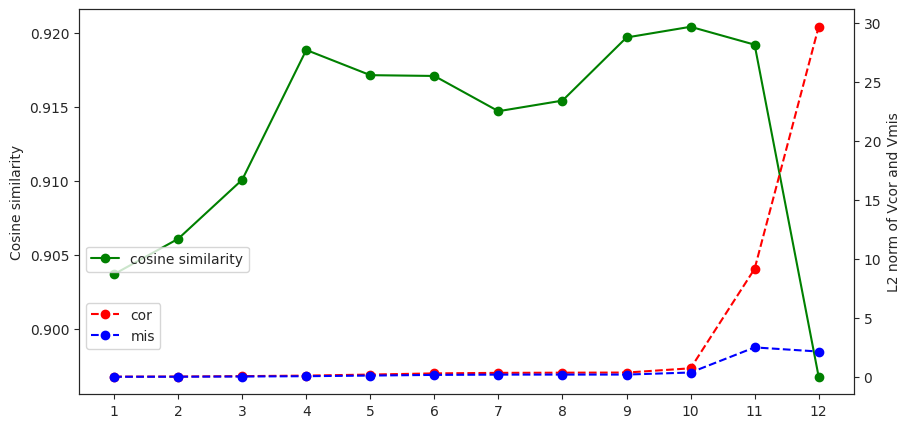

ba: intermediate, tgt_split: repair
vscores shape (cor): (3072, 12)
vscores shape (mis): (3072, 12)
sum(condition)=308


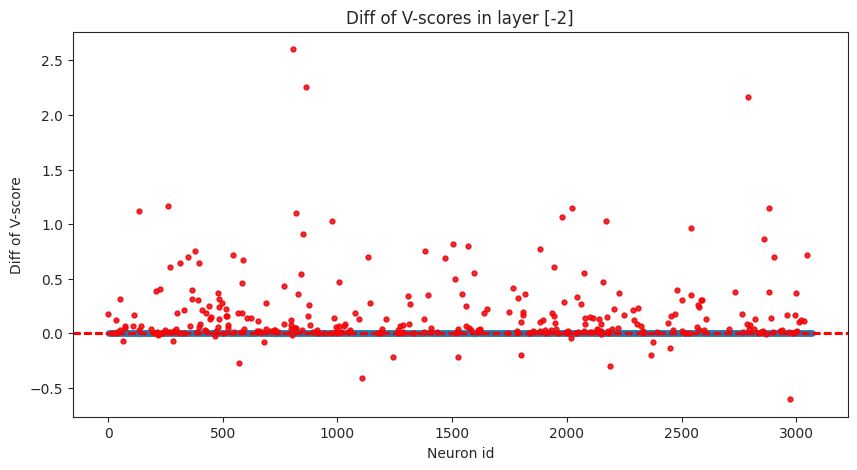

cosine_similarity=[0.75125085 0.76192214 0.93320111 0.72269611 0.83479419 0.83255743
 0.79428186 0.73085837 0.81832144 0.88937544 0.47472543 0.32857118]


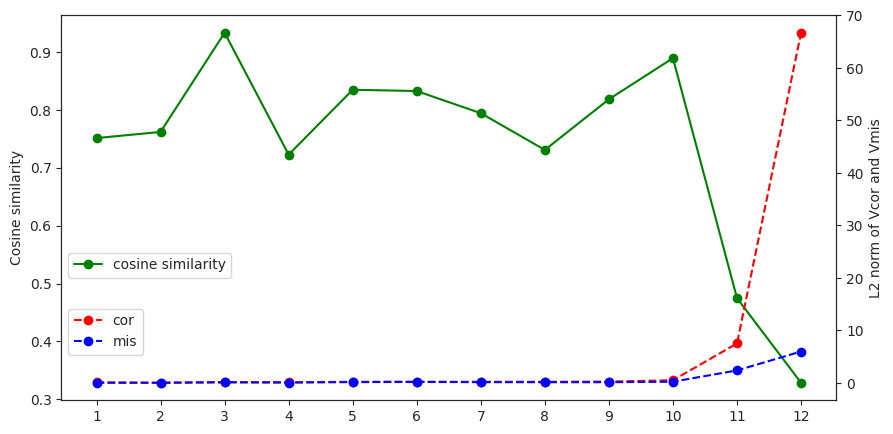

ba: after, tgt_split: repair
vscores shape (cor): (768, 12)
vscores shape (mis): (768, 12)
sum(condition)=77


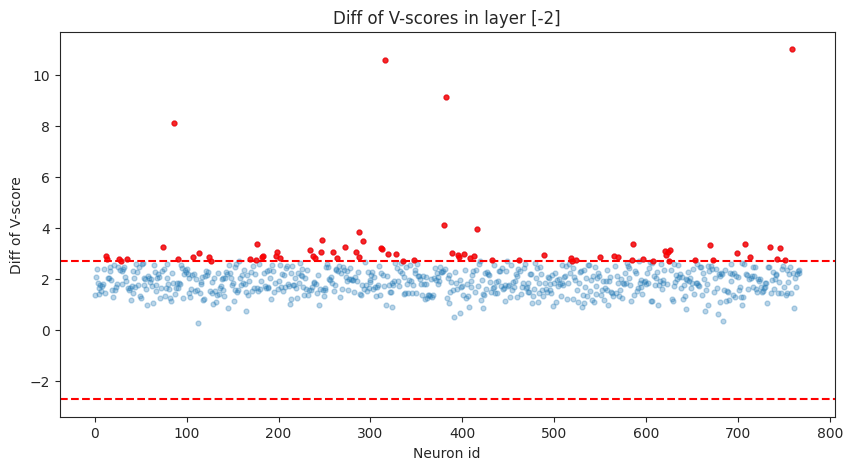

cosine_similarity=[0.82773385 0.8598923  0.90513409 0.91619647 0.91793332 0.91118413
 0.91255541 0.91785033 0.90673095 0.90600465 0.92235434 0.88826478]


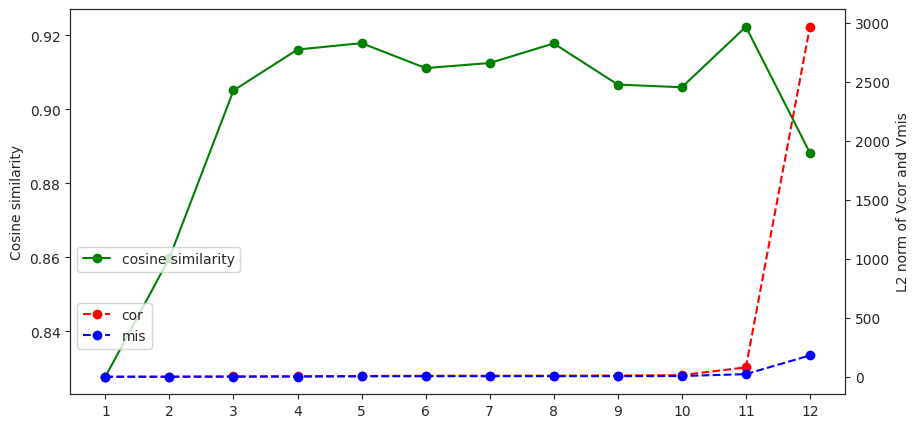

In [7]:
layers4show = [-2]
vdiff_dic = defaultdict(np.array)

for ba, vscore_dir in zip(["before", "intermediate", "after"], [vscore_before_dir, vscore_med_dir, vscore_after_dir]):
    vmap_dic = defaultdict(defaultdict)
    print(f"ba: {ba}, tgt_split: {tgt_split}")
    vmap_dic[tgt_split] = defaultdict(defaultdict)
    # 正解と不正解時のvscoreを読み込む
    for cor_mis in ["cor", "mis"]:
        vmap_dic[tgt_split][cor_mis] = defaultdict(np.array)
        ds_type = f"ori_{tgt_split}"
        if cor_mis == "cor":
            vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_all_label_{ds_type}_{cor_mis}.npy")
        else:
            vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_{slabel}to{tlabel}_{ds_type}_{cor_mis}.npy")
        vscores = np.load(vscore_save_path)
        vmap_dic[tgt_split][cor_mis] = vscores.T
        print(f"vscores shape ({cor_mis}): {vmap_dic[tgt_split][cor_mis].shape}")
    # vscoresのcorとmisの差分をヒートマップで可視化
    vmap_cor = vmap_dic[tgt_split]["cor"]
    vmap_mis = vmap_dic[tgt_split]["mis"]
    vmap_diff = vmap_cor - vmap_mis
    vdiff_dic[ba] = vmap_diff
    # 横軸をニューロン，縦軸をスコアとした折れ線グラフ
    plt.figure(figsize=(10, 5))
    # vmap[:, layers4show] の絶対値の上位10%だけマーカーの色を赤に変える
    top10 = np.percentile(np.abs(vmap_diff[:, layers4show]), 90)
    condition = np.abs(vmap_diff[:, layers4show]).reshape(-1) > top10
    print(f"sum(condition)={sum(condition)}")
    # top10の値に横線を引く
    plt.axhline(y=top10, color="red", linestyle="--")
    plt.axhline(y=-top10, color="red", linestyle="--")
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show]))), vmap_diff[:, layers4show], alpha=0.3, s=12)
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show])))[condition], vmap_diff[:, layers4show][condition], alpha=0.8, s=12, color="red")
    plt.xlabel("Neuron id")
    plt.ylabel("Diff of V-score")
    plt.title(f"Diff of V-scores in layer {layers4show}")
    plt.show()
    # vmap_dic[used_column][tgt_ct]["cor"] と vmap_dic[used_column][tgt_ct]["mis"] の，行ごとの内積を取る
    dot_products = np.sum(vmap_cor * vmap_mis, axis=0)
    a_norms = np.linalg.norm(vmap_cor, axis=0)
    b_norms = np.linalg.norm(vmap_mis, axis=0)
    cosine_similarity = dot_products / (a_norms * b_norms)
    print(f"cosine_similarity={cosine_similarity}") # corとmisのcos類似度
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(cosine_similarity, color="g", marker="o", label="cosine similarity")
    ax1.set_ylabel('Cosine similarity')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(a_norms, color="r", marker="o", linestyle="--", label="cor")
    ax2.plot(b_norms, color="b", marker="o", linestyle="--", label="mis")
    ax2.set_xlabel("Layer")
    ax2.set_ylabel("L2 norm of Vcor and Vmis")
    # グラフに凡例を追加
    ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.3))
    ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
    plt.xticks(np.arange(0, end_li-start_li, 1), np.arange(start_li+1, end_li+1, 1))
    plt.show()

# ViTレイヤの最終層

ba: before, tgt_split: repair
vscores shape (cor): (768, 12)
vscores shape (mis): (768, 12)
sum(condition)=77


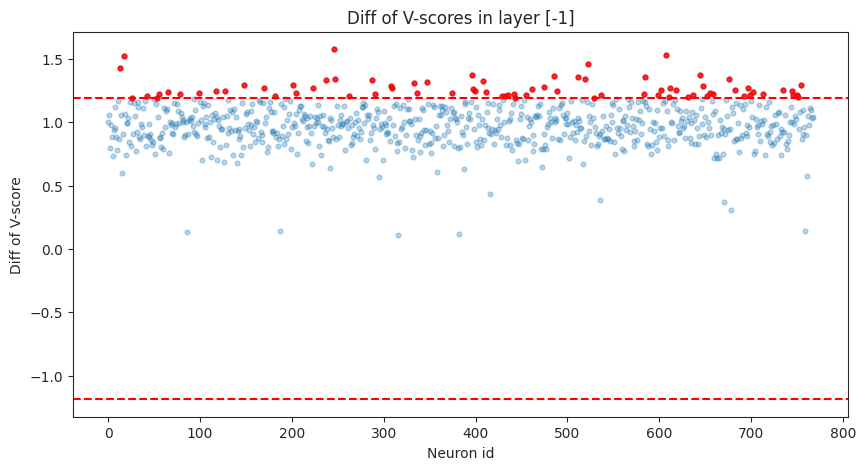

cosine_similarity=[0.90370574 0.90608983 0.91007541 0.91882469 0.91712524 0.91707161
 0.91469489 0.91541015 0.91966586 0.9203881  0.91918057 0.89678558]


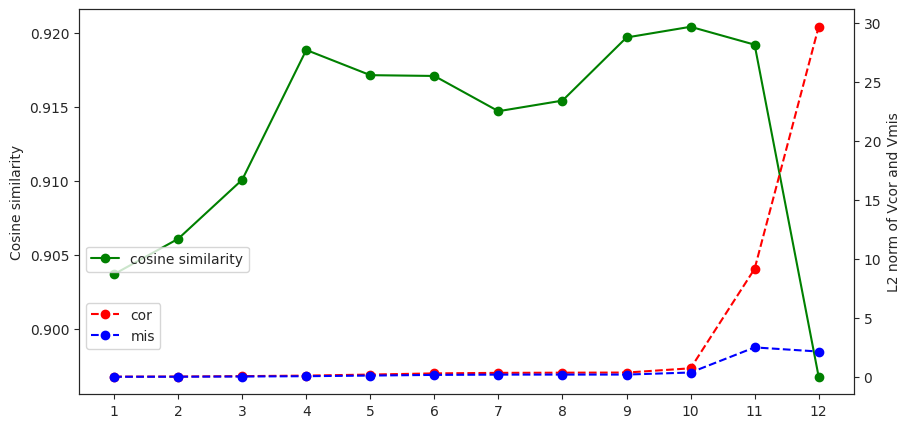

ba: intermediate, tgt_split: repair
vscores shape (cor): (3072, 12)
vscores shape (mis): (3072, 12)
sum(condition)=308


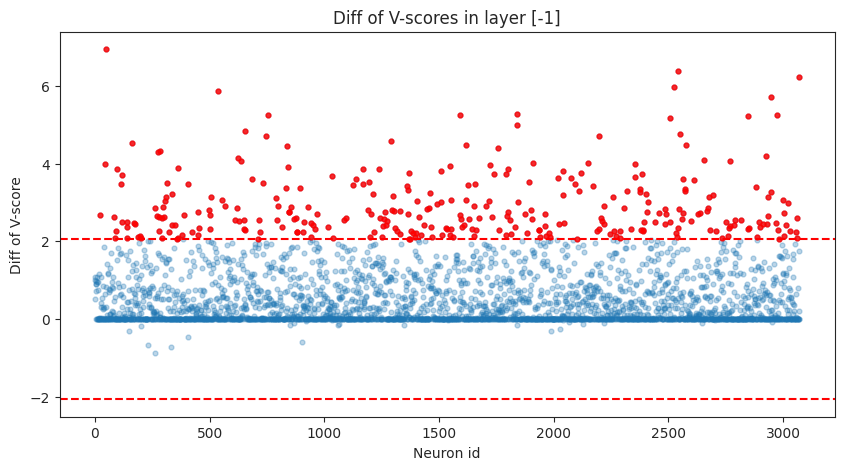

cosine_similarity=[0.75125085 0.76192214 0.93320111 0.72269611 0.83479419 0.83255743
 0.79428186 0.73085837 0.81832144 0.88937544 0.47472543 0.32857118]


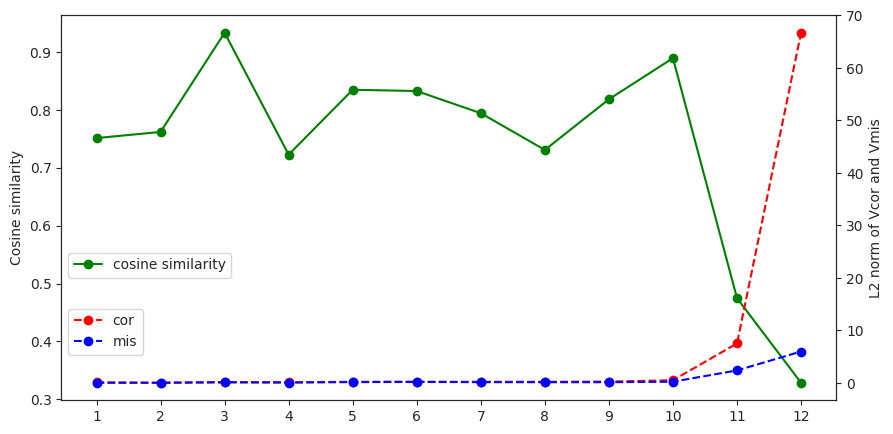

ba: after, tgt_split: repair
vscores shape (cor): (768, 12)
vscores shape (mis): (768, 12)
sum(condition)=77


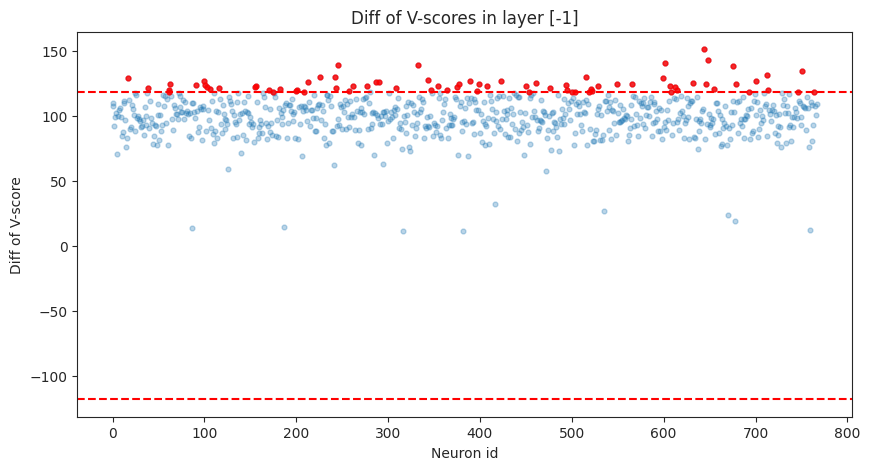

cosine_similarity=[0.82773385 0.8598923  0.90513409 0.91619647 0.91793332 0.91118413
 0.91255541 0.91785033 0.90673095 0.90600465 0.92235434 0.88826478]


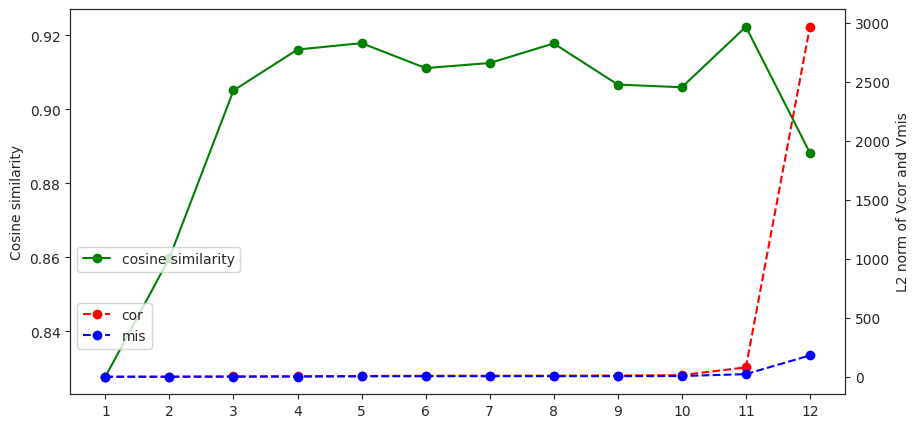

In [8]:
layers4show = [-1]
vdiff_dic = defaultdict(np.array)

for ba, vscore_dir in zip(["before", "intermediate", "after"], [vscore_before_dir, vscore_med_dir, vscore_after_dir]):
    vmap_dic = defaultdict(defaultdict)
    print(f"ba: {ba}, tgt_split: {tgt_split}")
    vmap_dic[tgt_split] = defaultdict(defaultdict)
    # 正解と不正解時のvscoreを読み込む
    for cor_mis in ["cor", "mis"]:
        vmap_dic[tgt_split][cor_mis] = defaultdict(np.array)
        ds_type = f"ori_{tgt_split}"
        if cor_mis == "cor":
            vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_all_label_{ds_type}_{cor_mis}.npy")
        else:
            vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_{slabel}to{tlabel}_{ds_type}_{cor_mis}.npy")
        vscores = np.load(vscore_save_path)
        vmap_dic[tgt_split][cor_mis] = vscores.T
        print(f"vscores shape ({cor_mis}): {vmap_dic[tgt_split][cor_mis].shape}")
    # vscoresのcorとmisの差分をヒートマップで可視化
    vmap_cor = vmap_dic[tgt_split]["cor"]
    vmap_mis = vmap_dic[tgt_split]["mis"]
    vmap_diff = vmap_cor - vmap_mis
    vdiff_dic[ba] = vmap_diff
    # 横軸をニューロン，縦軸をスコアとした折れ線グラフ
    plt.figure(figsize=(10, 5))
    # vmap[:, layers4show] の絶対値の上位10%だけマーカーの色を赤に変える
    top10 = np.percentile(np.abs(vmap_diff[:, layers4show]), 90)
    condition = np.abs(vmap_diff[:, layers4show]).reshape(-1) > top10
    print(f"sum(condition)={sum(condition)}")
    # top10の値に横線を引く
    plt.axhline(y=top10, color="red", linestyle="--")
    plt.axhline(y=-top10, color="red", linestyle="--")
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show]))), vmap_diff[:, layers4show], alpha=0.3, s=12)
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show])))[condition], vmap_diff[:, layers4show][condition], alpha=0.8, s=12, color="red")
    plt.xlabel("Neuron id")
    plt.ylabel("Diff of V-score")
    plt.title(f"Diff of V-scores in layer {layers4show}")
    plt.show()
    # vmap_dic[used_column][tgt_ct]["cor"] と vmap_dic[used_column][tgt_ct]["mis"] の，行ごとの内積を取る
    dot_products = np.sum(vmap_cor * vmap_mis, axis=0)
    a_norms = np.linalg.norm(vmap_cor, axis=0)
    b_norms = np.linalg.norm(vmap_mis, axis=0)
    cosine_similarity = dot_products / (a_norms * b_norms)
    print(f"cosine_similarity={cosine_similarity}") # corとmisのcos類似度
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(cosine_similarity, color="g", marker="o", label="cosine similarity")
    ax1.set_ylabel('Cosine similarity')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(a_norms, color="r", marker="o", linestyle="--", label="cor")
    ax2.plot(b_norms, color="b", marker="o", linestyle="--", label="mis")
    ax2.set_xlabel("Layer")
    ax2.set_ylabel("L2 norm of Vcor and Vmis")
    # グラフに凡例を追加
    ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.3))
    ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
    plt.xticks(np.arange(0, end_li-start_li, 1), np.arange(start_li+1, end_li+1, 1))
    plt.show()

# FLのトライアル

In [9]:
# just for check
for k, v in vdiff_dic.items():
    print(f"{k}: {v.shape}") # これは全レイヤー分入ってる

before: (768, 12)
intermediate: (3072, 12)
after: (768, 12)


In [10]:
# 特定のレイヤだけ取り出す
tgt_layer = 11
tgt_vdiff_dic = defaultdict(np.array)
for k, v in vdiff_dic.items():
    tgt_vdiff_dic[k] = np.abs(v[:, tgt_layer])
    print(f"{k}: {tgt_vdiff_dic[k].shape}")
    print(f"[min, max] = [{np.min(tgt_vdiff_dic[k])}, {np.max(tgt_vdiff_dic[k])}]")

before: (768,)
[min, max] = [0.11133159656561507, 1.5762001128627527]
intermediate: (3072,)
[min, max] = [1.8526724655422497e-07, 6.944312172408372]
after: (768,)
[min, max] = [11.158105956581311, 151.17053950987088]


In [11]:
# 降順のランクをペアにしたdictにする
tgt_vdiff_dic_with_rank = defaultdict(defaultdict)

def rank_descending(x):
    # x を降順に並べ替えるためのインデックスを取得
    sorted_indices = np.argsort(x)[::-1]
    # 順位用の空の配列を準備
    ranks = np.empty_like(sorted_indices)
    # インデックスを使って順位を設定
    ranks[sorted_indices] = np.arange(len(x))
    return ranks

for k, v in tgt_vdiff_dic.items():
    tgt_vdiff_dic_with_rank[k]["vdiff"] = v
    tgt_vdiff_dic_with_rank[k]["rank"] = rank_descending(v)
    print(f"(vdiff) {k}: {tgt_vdiff_dic_with_rank[k]['vdiff'].shape}")
    print(f"(rank) {k}: {tgt_vdiff_dic_with_rank[k]['rank'].shape}")

(vdiff) before: (768,)
(rank) before: (768,)
(vdiff) intermediate: (3072,)
(rank) intermediate: (3072,)
(vdiff) after: (768,)
(rank) after: (768,)


In [12]:
def return_rank(x, i, order="desc"):
    # x[i] の順位を返す
    if order == "desc":
        return np.argsort(x)[::-1].tolist().index(i)
    elif order == "asc":
        return np.argsort(x).tolist().index(i)
    else:
        raise NotImplementedError

In [13]:
# tgt_vdiff_dic_with_rank[k]["rank"]のi番目が，tgt_vdiff_dic_with_rank[k]["vdiff"]のi番めの順位になっていることを確認
for i, r in enumerate(tgt_vdiff_dic_with_rank["after"]["rank"]):
    assert return_rank(tgt_vdiff_dic_with_rank["after"]["vdiff"], i) == r, f"Error: {i}, {r}"

In [14]:
# tgt_vdiff_dic_with_rankのbefore, intermediate, afterでそれぞれランクがtop x のインデックスを取得
top_idx_dic = defaultdict(list)
for k, v in tgt_vdiff_dic_with_rank.items():
    if k == "intermediate":
        topx = 20
    else:
        topx = 5
    top_idx_dic[k] = np.where(v["rank"] < topx)[0]
    print(f"{k}: {top_idx_dic[k]}")

before: [ 13  17 246 522 607]
intermediate: [  49  163  536  654  744  756 1290 1591 1618 1838 1842 2196 2506 2526
 2542 2549 2849 2946 2973 3071]
after: [246 333 602 644 648]


In [15]:
# top_idx_dic[k]のデカルト積を取る
from itertools import product
pos_before = list(product(top_idx_dic["before"], top_idx_dic["intermediate"]))
pos_after = list(product(top_idx_dic["intermediate"], top_idx_dic["after"]))
print(len(pos_before), len(pos_after))

100 100


In [16]:
tot_params = 1
for k, v in top_idx_dic.items():
    print(f"k={k}, len(v)={len(v)}")
    tot_params *= len(v)
tot_params

k=before, len(v)=5
k=intermediate, len(v)=20
k=after, len(v)=5


500

In [17]:
tgt_vdiff_dic_with_rank["after"]["vdiff"][top_idx_dic["after"]]

array([138.71942445, 139.10671708, 140.70670544, 151.17053951,
       142.67120733])

In [18]:
np.sort(tgt_vdiff_dic_with_rank["after"]["vdiff"])[::-1][:5]

array([151.17053951, 142.67120733, 140.70670544, 139.10671708,
       138.71942445])

順位の情報ではなくvdiff自体の値を直接使ってパレートフロントを取ればいい気もしてきた